In [792]:
%reload_ext autoreload
%autoreload 2

import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_durs = np.load(
    '/home/stanislavv/data/librimeta/durs/ljspeech_300epochs-qn15x5-eqlen_all-1s/train.npy',
    allow_pickle=True,
)
len(train_durs)

13036

In [3]:
eval_durs = np.load(
    '/home/stanislavv/data/librimeta/durs/ljspeech_300epochs-qn15x5-eqlen_all-1s/eval.npy', 
    allow_pickle=True,
)
len(eval_durs)

64

In [5]:
all_durs = train_durs + eval_durs

ValueError: operands could not be broadcast together with shapes (13036,2) (64,2) 

In [8]:
max(sum(b) + sum(d) for b, d in eval_durs)

870

In [9]:
max(sum(b) + sum(d) for b, d in train_durs)

870

In [28]:
sns.set()

## Blanks

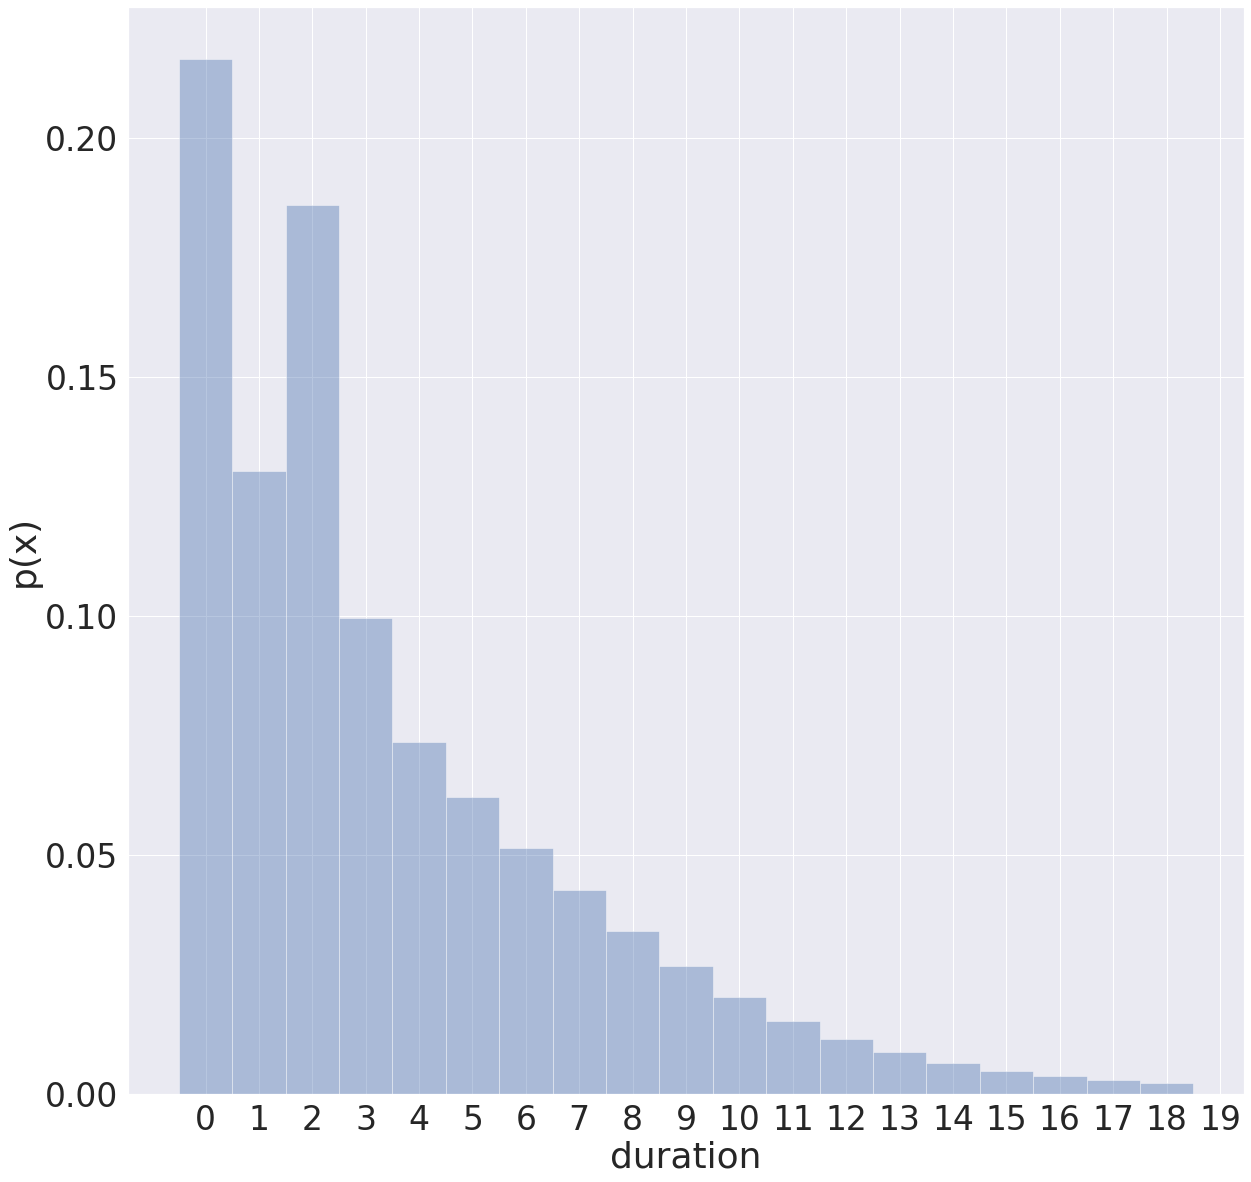

In [33]:
sns.set(font_scale=3)
plt.figure(figsize=(20, 20))
ax = sns.distplot(ds, kde=False, bins=np.arange(20) - 0.5, norm_hist=True)
plt.ylabel('p(x)')
plt.xlabel('duration')
ax.set(xticks=range(20));
plt.setp(ax.xaxis.get_majorticklabels(), ha='center', x=-10);

## Durs

In [36]:
max(ds)

7

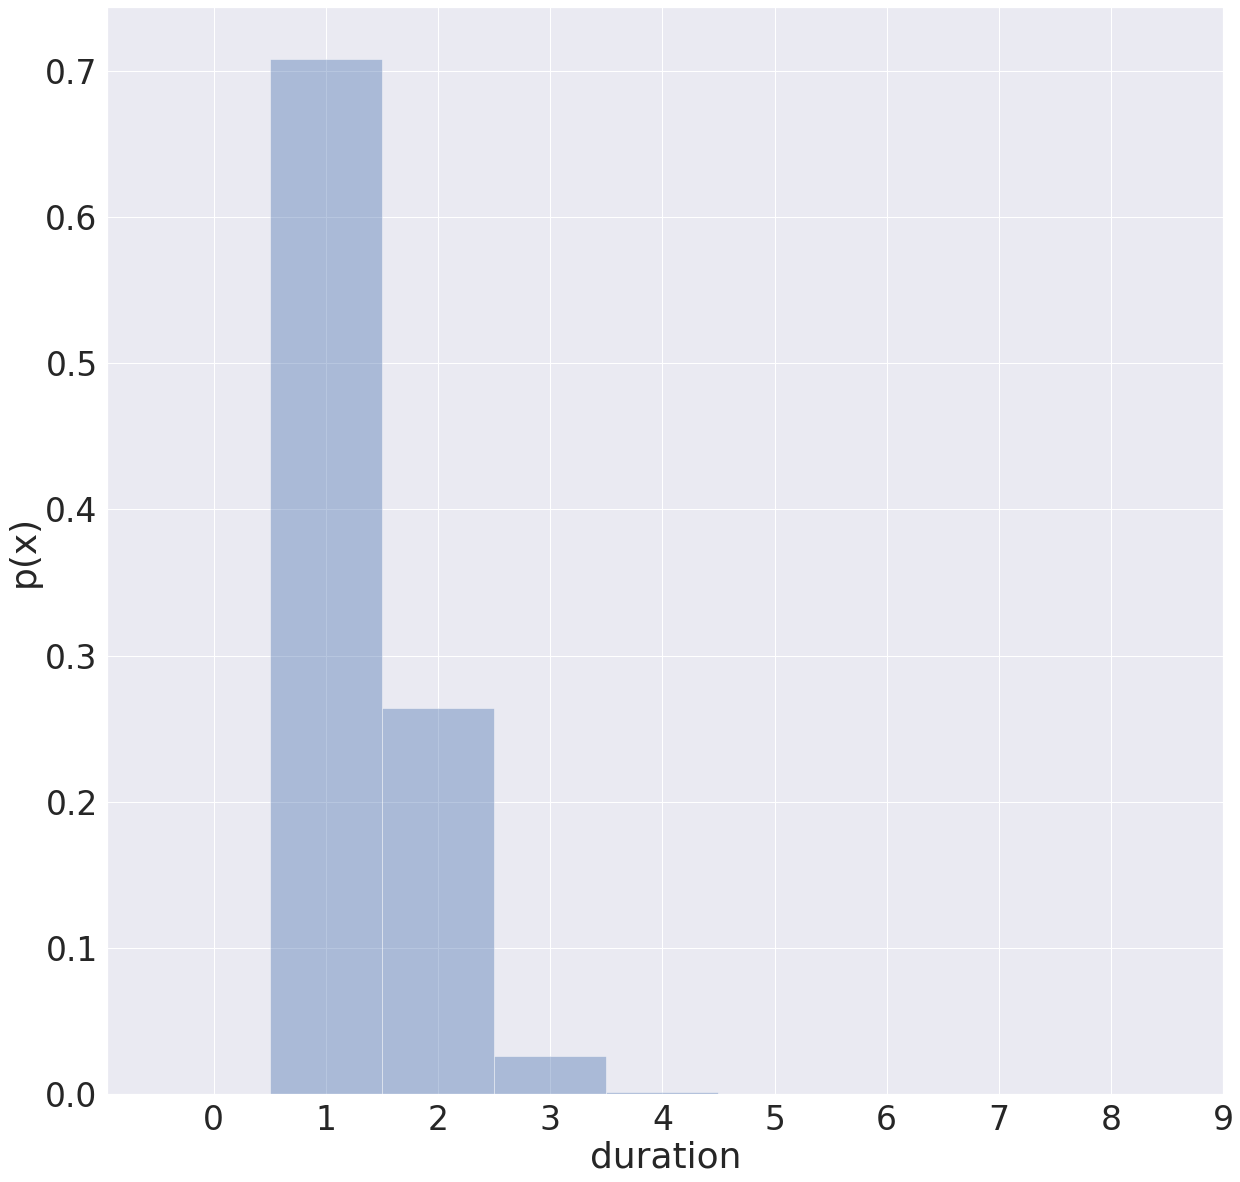

In [31]:
sns.set(font_scale=3)
plt.figure(figsize=(20,20))
ax = sns.distplot(ds, kde=False, bins=np.arange(10) - 0.5, norm_hist=True)
plt.ylabel('p(x)')
plt.xlabel('duration')
ax.set(xticks=range(10));
plt.setp(ax.xaxis.get_majorticklabels(), ha='center', x=-10);

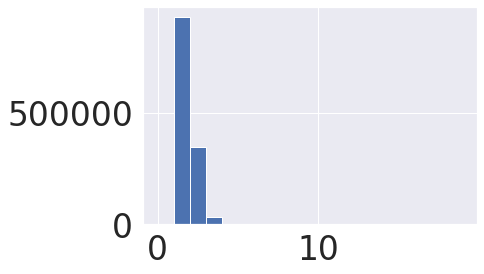

In [35]:
ds = []
for _, d in train_durs:
    ds.extend(d)
for _, d in eval_durs:
    ds.extend(d)

plt.hist(ds, bins=range(20));

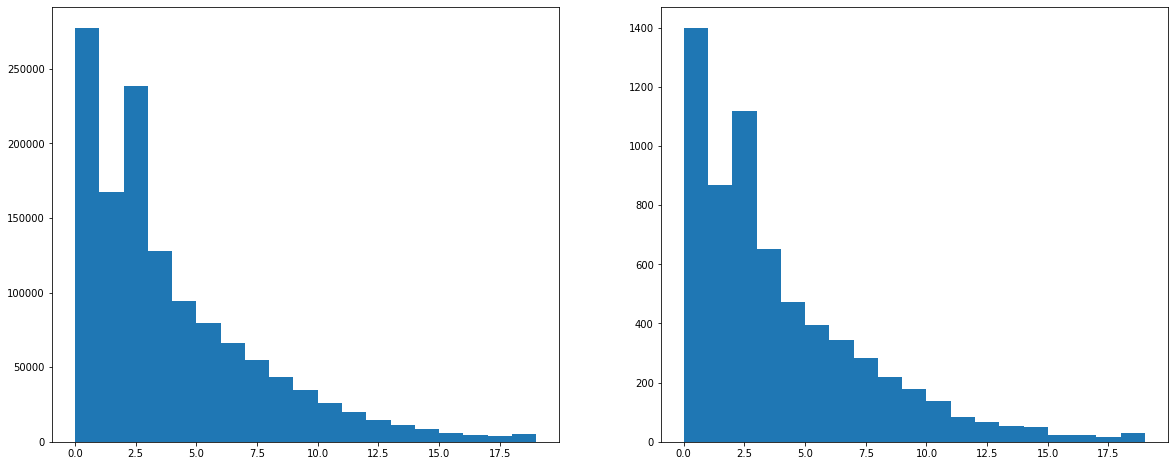

In [10]:
t, e = [], []
for b, _ in train_durs:
    t.extend(b)
for b, _ in eval_durs:
    e.extend(b)

plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.hist(t, bins=range(20));
plt.subplot(122)
plt.hist(e, bins=range(20));

In [6]:
blanks, durs = train_durs[0]
print(*blanks)
print(*durs)

14 2 0 8 4 2 9 1 0 0 20 3 2 8 15 2 2 6 0 20 6 2 8 2 63 1 5 3 9 3 15 3 18 1 5 3 0 7 3 1 6 17 2 9 0 24 5 2 10 2 2 5 8 2 8 0 28 1
1 1 1 2 2 1 1 1 2 3 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1


In [1263]:
def parse(s):
    name, p = s.split('|')
    return name, float(p)


parse('shake_biased|0.4')

('shake_biased', 0.4)

In [1335]:
sns.set_style("dark")

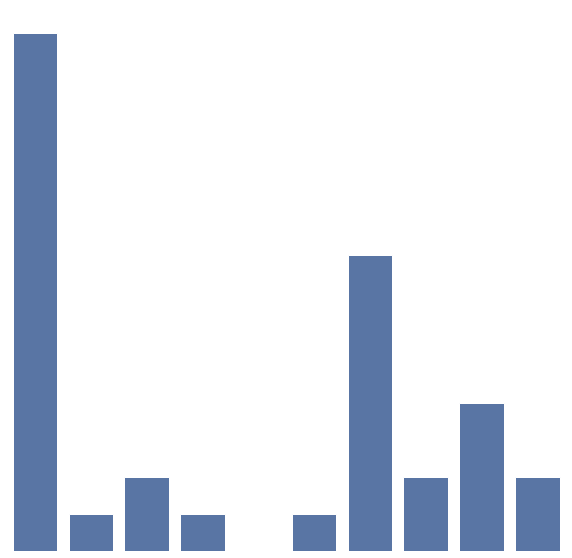

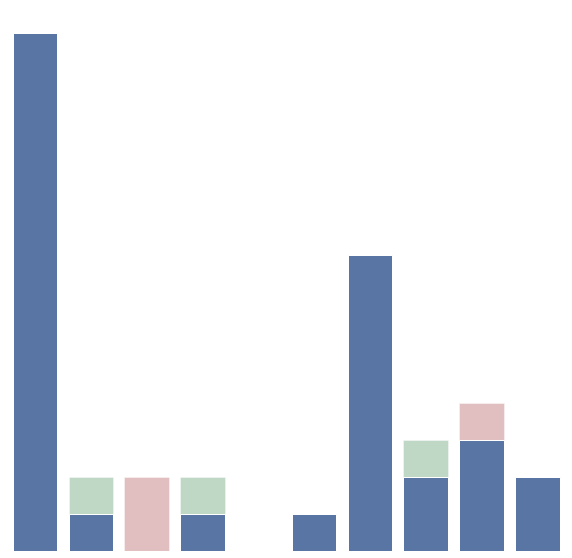

In [1339]:
bd = merge(blanks, durs)
bd_aug = merge(*shake_unbiased(blanks, durs))
sns.set()
plt.figure(figsize=(10, 10))
plt.axis('off')
sns.barplot(x=list(range(10)), y=bd[:10], orient='v', color='b', alpha=1);
plt.figure(figsize=(10, 10))
plt.axis('off')
sns.barplot(x=list(range(10)), y=bd[:10], orient='v', color='r', alpha=.4);
sns.barplot(x=list(range(10)), y=bd_aug[:10], orient='v', color='g', alpha=.4);
sns.barplot(x=list(range(10)), y=np.minimum(bd, bd_aug)[:10], orient='v', color='b', alpha=1);

In [812]:
def merge(b, d):
    result = []
    for b1, d1 in zip(b, d):
        result.extend([b1, d1])
    
    result.append(b[-1])
    return np.array(result)


def split(durs):
    return np.array(durs[::2]), np.array(durs[1::2])

In [ ]:
def shake_left(bd):
    bd_pl, bd_m = split2(bd)
    bd_l = np.minimum(bd_pl, np.hstack([[bd[-1]], bd[:-1]]))
    bd_m += bd_pl - bd_l

    assert bd_m.sum() + bd_l.sum() == total

    bd = bd_m
    bd[:-1] += bd_l[1:]
    bd[-1] += bd_l[0]

    return bd

In [1253]:
def test(b, d, shake):
    b, d = np.array(b), np.array(d)
    before = merge(b, d)
    afters = []
    for _ in tqdm.notebook.trange(100000):
        afters.append(merge(*shake(b, d, p=0.05)))
    mean = np.stack(afters).mean(0)
    std = np.stack(afters).std(0)
    print(before[:10])
    print(mean[:10])
    print(std[:10])
    print('Mean of stds:', std.mean())

In [1255]:
def shake_biased(b, d, p=0.1):
    b, d, total = b.copy(), d.copy(), sum(b) + sum(d)

    def split2(x):
        xl = np.random.binomial(x, p, size=x.shape)
        return xl, x - xl

    def split3(x):
        xl, xm = split2(x)
        xr, xm = split2(xm)
        return xl, xm, xr

    bdl, bdm, bdr = split3(merge(b, d))
    bd = bdm + np.roll(bdl, -1) + np.roll(bdr, +1)
    b, d = split(bd)

    assert sum(b) + sum(d) == total

    return b, d


test(blanks, durs, shake_biased)


[14  1  2  1  0  1  8  2  4  2]
[12.7351   1.66521  1.90542  0.99443  0.0986   1.30427  7.36501  2.38768
  3.80306  2.09293]
[1.15146341 0.90663425 0.51849265 0.42263338 0.30701472 0.68652004
 0.92014004 0.8523991  0.73152897 0.67097989]
Mean of stds: 0.7986657984401548


In [1256]:
def shake_unbiased(b, d, p=0.1):
    b, d, total = b.copy(), d.copy(), sum(b) + sum(d)

    def split2(x, mm):
        xl = np.random.binomial(np.minimum(x, mm), p, size=x.shape)
        return xl, x - xl

    def split3(x):
        xl, xm = split2(x, np.roll(x, +1))
        xr, xm = split2(xm, np.roll(x, -1))
        return xl, xm, xr

    bdl, bdm, bdr = split3(merge(b, d))
    bd = bdm + np.roll(bdl, -1) + np.roll(bdr, +1)
    b, d = split(bd)

    assert sum(b) + sum(d) == total

    return b, d


test(blanks, durs, shake_unbiased)


[14  1  2  1  0  1  8  2  4  2]
[13.99578  1.00315  1.99577  1.00141  0.       0.99969  7.99953  2.00847
  3.99341  2.00412]
[0.43407625 0.42593436 0.43274947 0.30920545 0.         0.30810697
 0.53285062 0.60444872 0.61428542 0.60430375]
Mean of stds: 0.41571037150741585


In [1242]:
def shake_local(b, d, p):
    b, d, total = b.copy(), d.copy(), sum(b) + sum(d)

    def split2(x):
        xl = np.random.binomial(x, p, size=x.shape)
        return xl, x - xl

    bd = merge(b, d)
    
    mm = np.minimum(bd, np.roll(bd, +1))
    go, stay = split2(mm)

    b, d = split(bd)

    assert b.sum() + d.sum() == total

    return b, d


def test(b, d, shake):
    b, d = np.array(b), np.array(d)
    before = merge(b, d)
    afters = []
    for _ in tqdm.notebook.trange(100000):
        afters.append(merge(*shake(b, d, p=0.05)))
    mean = np.stack(afters).mean(0)
    std = np.stack(afters).std(0)
    print(before[:10])
    print(mean[:10])
    print(std[:10])


# test([2, 0], [1])
b, d = np.array([2, 0]), np.array([1])
print(merge(b, d)[:10])
b, d = shake_local(b, d, p=0.5)
print(merge(b, d)[:10])

[2 1 0]
[0 1 0]
[2 1 0]


In [1088]:
def shake_all(b, d, p):
    b, d, total = b.copy(), d.copy(), sum(b) + sum(d)

    def split2(x, p):
        xl = np.random.binomial(x, p, size=x.shape)
        return xl, x - xl

    bd = merge(b, d)
    give, left = split2(bd, p)

    if give.sum():
        for i in np.random.choice(len(left), size=give.sum(), p=give / give.sum()):
            left[i] += 1

    b, d = split(left)

    assert sum(b) + sum(d) == total

    return b, d


before = merge(blanks, durs)
afters = []
for _ in tqdm.notebook.trange(100000):
    afters.append(merge(*shake_all(blanks, durs, p=0.05)))
mean = np.stack(afters).mean(0)
std = np.stack(afters).std(0)
print(before[:10])
print(mean[:10])
print(std[:10])


[14  1  2  1  0  1  8  2  4  2]
[13.99801  0.9997   2.00063  1.00121  0.       1.00126  7.99844  2.00093
  4.00077  2.00096]
[0.80254971 0.21161264 0.31123882 0.22205525 0.         0.21706776
 0.61129172 0.3093366  0.43362358 0.30896453]


In [1079]:
print(merge(blanks, durs)[:10])
b, d = shake_all(blanks, durs, p=0.3)
print(merge(b, d)[:10])

[14  1  2  1  0  1  8  2  4  2]
[14  0  2  3  0  2  6  2  3  2]


In [740]:
print(merge(blanks, durs)[:10])
b, d = shake_all(blanks, durs, p=0.5)
print(merge(b, d)[:10])

[14  1  2  1  0  1  8  2  4  2]
bl: [14  2  0  8  4  2  9  1  0  0]
bm: [0 0 0 0 0 0 0 0 0 0]
br: [0 0 0 0 0 0 0 0 0 0]
[15  2  1  0  1  8  2  4  2  2]


In [240]:
def shake_blanks(b, d, p=0.1):
    b, d, total = b.copy(), d.copy(), sum(b) + sum(d)

    def split2(x):
        xl = np.random.binomial(x, p)
        return xl, x - xl

    def split3(x):
        xl, xm = split2(x)
        xr, xm = split2(xm)
        return xl, xm, xr
    
    n, m = len(b), len(d)
    nb = np.zeros_like(b)
    for i in range(len(b)):
        bl, bm, br = split3(b[i])

        nb[i] += bm

        if i > 0:
            nb[i - 1] += bl
        else:
            nb[i] += bl

        if i < m:
            nb[i + 1] += br
        else:
            nb[i] += br

    b = nb
    assert sum(b) + sum(d) == total

    return b, d


print(blanks)
b, d = shake_blanks(blanks, durs, 0.05)
print(b)

[14  2  0  8  4  2  9  1  0  0 20  3  2  8 15  2  2  6  0 20  6  2  8  2
 63  1  5  3  9  3 15  3 18  1  5  3  0  7  3  1  6 17  2  9  0 24  5  2
 10  2  2  5  8  2  8  0 28  1]
[13  3  0  7  5  3  6  3  0  1 19  3  4  9 12  1  3  5  1 20  5  4  7  2
 60  4  5  3  8  4 15  3 18  0  6  3  0  7  3  1  7 16  2  9  0 24  5  3
  9  2  2  6  7  2  8  1 27  1]


In [55]:
class BDAugs:
    @staticmethod
    def shake(b, d, p=0.1):
        b, d, total = b.copy(), d.copy(), sum(b) + sum(d)
        
        def split2(x):
            xl = np.random.binomial(x, p)
            return xl, x - xl
        
        def split3(x):
            xl, xm = split2(x)
            xr, xm = split2(xm)
            return xl, xm, xr

        n, m = len(b), len(d)
        nb = np.zeros_like(b)
        for i in range(len(b)):
            bl, bm, br = split3(b[i])

            nb[i] += bm

            if i > 0:
                d[i - 1] += bl
            else:
                nb[i] += bl

            if i < m:
                d[i] += br
            else:
                nb[i] += br
        
        b = nb
        assert sum(b) + sum(d) == total

        return b, d
    
    @staticmethod
    def zero_out(b, d, p=0.1):
        b, d, total = b.copy(), d.copy(), sum(b) + sum(d)
        
        mask = np.random.binomial(1, size=d.size, p=p).astype(bool)
        b[:-1][mask] += d[mask]
        d[mask] -= d[mask]
        
        assert sum(b) + sum(d) == total

        return b, d

    @staticmethod
    def compose(augs):
        def pipe(b, d, p=0.1):
            for aug in augs:
                b, d = aug(b, d, p=p)
            
            return b, d
        
        return pipe


print(*durs)
_, new_durs = BDAugs.compose([BDAugs.shake])(blanks, durs, p=0.05)
print(*new_durs)

1 1 1 2 2 1 1 1 2 3 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1
1 2 1 2 2 1 1 1 2 3 1 1 2 3 2 1 2 1 3 1 1 1 2 2 3 1 1 2 1 4 1 1 1 1 1 1 1 3 2 1 2 2 1 2 2 3 4 1 2 1 2 5 1 1 2 2 1
